# Clustering on mixed data-types


### 1. Introduction: 

This article focusses on theory, method and practical application of clustering of datasets with mixed datatypes. Many real world datasets include combinations of numerical, ordinal (e.g. small, medium, large), and nomial (e.g. France, China, India) data features. Whereas many popular clustering algorithms such as Kmeans are suitable only for either numerical or categorical datatypes independantly. Sklearn provides and excellent [introduction to clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering) methods. Lets begin.

Cluster analysis (clustering) is the task of assigning sets of objects within a population in such a way that objects in the same group (cluster) are more similar to one another than to those in other clusters. Clustering is a form of unsupervised learning as the number, size and distribution of clusters is unknown a priori.

Clustering can be applied to a variety of different problems and domains including: customer segmentation for retail sales and marketing, identifying higher or lower risk groups within [insurance portfolios](https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf), to finding [storm systems on Jupyter](https://astronomycommunity.nature.com/users/253561-ingo-waldmann/posts/48323-deep-learning-saturn), and even [galaxies far far away](https://arxiv.org/abs/1404.3097).

***Aim:***
*To define a strategy and method to cluster large datasets containing a variety of dataype's*

***Objectives:***
1. To research and review clustering techniques for mixed datatype datasets. 
1. To research and review feature encoding and engineering strategies. 
1. To apply and review clustering methods on a test dataset.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### 2. Case Study: 
California auto-insurance claims [dataset](https://www.kaggle.com/xiaomengsun/car-insurance-claim-data)

[***Data dictionary***](https://rpubs.com/data_feelings/msda_data621_hw4), includes:
- Bluebook = car re-sale value. 
- MVR_PTS = [MotorVehicleRecordPoints (MVR) ](https://www.wnins.com/losscontrolbulletins/MVREvaluation.pdf) details an individual’s past driving history indicating violations and accidents over a specified period
- TIF = Time In Force / customer lifetime
- YOJ = years in job
- CLM_FRQ = # of claims in past 5 years
- OLDCLAIM = sum $ of claims in past 5 years

In [2]:
# load data
DATA_PATH = os.path.join(os.getcwd(),'../_data')
df = pd.read_csv(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim.csv'),low_memory=False,)

# convert object to numerical
df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]] = df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0)

# clean textual classes
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(df.columns,df.dtypes)}

df[:2]

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,MAR,60.0,0,11.0,67349.0,NO,0.0,NO,...,MINIVAN,YES,4461.0,2,NO,3,0.0,18.0,0,HIGHLYURBANURBAN
1,132761049,0,JAN,43.0,0,11.0,91449.0,NO,257252.0,NO,...,MINIVAN,YES,0.0,0,NO,0,0.0,1.0,0,HIGHLYURBANURBAN


### 3 Method

#### 3.1 Data Preparation
 - remove or fill null values

In [3]:
# copy df
tdf = df.copy()

# drop ID and Birth
tdf.drop(labels=['ID','BIRTH'],axis=1,inplace=True)

In [4]:
# remove all nan values
tdf['OCCUPATION'].fillna('OTHER',inplace=True)
for col in ['AGE','YOJ','CAR_AGE']:
    tdf[col].fillna(tdf[col].mean(),inplace=True)
if tdf.isnull().sum().sum() == 0: print('No NaNs')

No NaNs


***inspect and clean***

In [5]:
data_meta = pd.DataFrame(tdf.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'

# exclude known numericals
data_meta.loc[(data_meta['num']<=15) & (~data_meta['name'].isin(['MVR_PTS','CLM_FREQ','CLAIM_FLAG'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['CLM_FREQ','CLAIM_FLAG']),'type']='claim'

cat_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
num_features = list(data_meta.loc[data_meta['type']=='numerical','name'])

In [6]:
# shorten names
tdf['URBANICITY'] = tdf['URBANICITY'].map({'HIGHLYURBANURBAN':'URBAN','HIGHLYRURALRURAL':'RURAL'})
tdf['EDUCATION'] = tdf['EDUCATION'].map({'HIGHSCHOOL':'HSCL', 'BACHELORS':'BSC', 'MASTERS':'MSC','PHD':'PHD'})
tdf['CAR_TYPE'] = tdf['CAR_TYPE'].map({'MINIVAN':'MVAN', 'VAN':'VAN', 'SUV':'SUV', 'SPORTSCAR':'SPRT', 'PANELTRUCK':'PTRK', 'PICKUP':'PKUP'})

In [7]:
# Mosaic Plots
# https://rpubs.com/data_feelings/msda_data621_hw4
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.graphics.mosaicplot import mostaticmethodc

# props = {}
# for car in tdf['CAR_TYPE'].unique():
#     for i,color in zip([0,1],['grey','blue']):
#         props[(str(i),car)] = {'color':color}
# props

# m = mosaic(tdf, ['CAR_TYPE','CLAIM_FLAG',], title='DataFrame as Source',properties=props)
# plt.show()

***categorical feature counts***

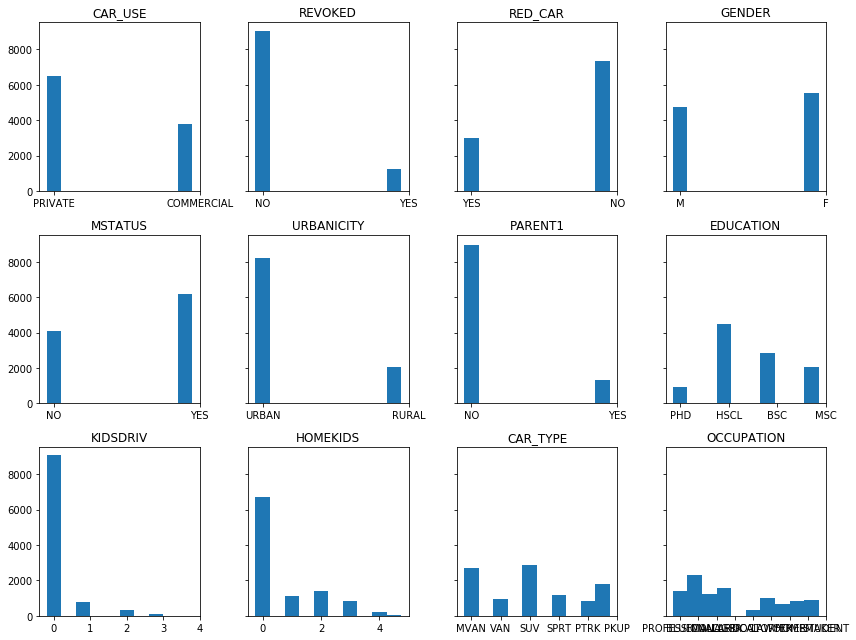

In [8]:
fig,axs = plt.subplots(3,4,figsize=(12,9),sharey=True)

for ax,feat in zip(axs.flatten(),cat_features):
    ax.hist(tdf[feat],align='left')
    ax.set_title(feat)
plt.tight_layout()

***How are claims distributed amongst categoricals?***

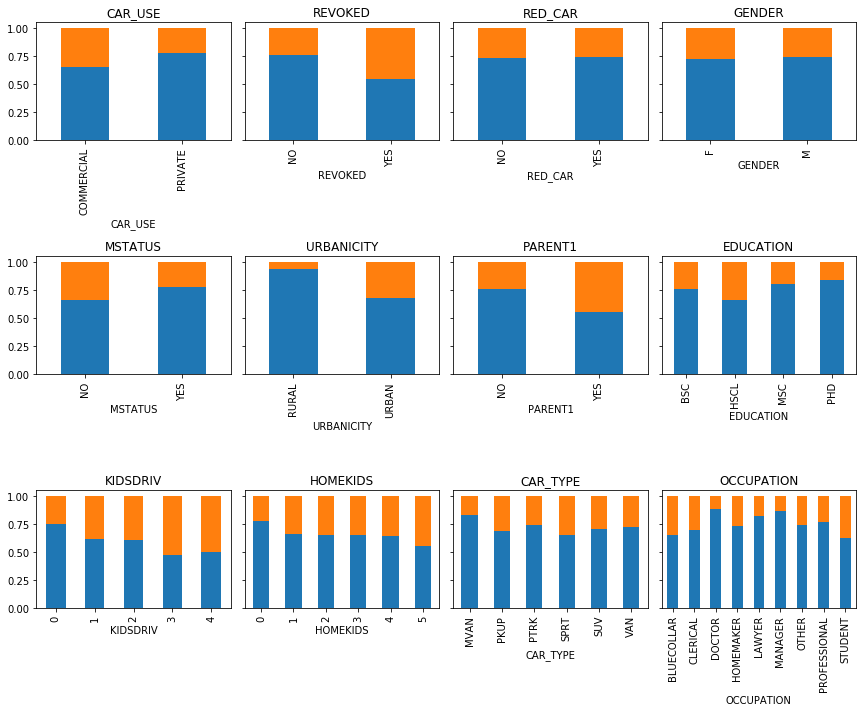

In [9]:
fig,axs = plt.subplots(3,4,figsize=(12,10),sharey=True)

for ax,feat in zip(axs.flatten(),cat_features):
    ((pd.crosstab(tdf['CLAIM_FLAG'],tdf[feat])) / (pd.crosstab(tdf['CLAIM_FLAG'],tdf[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
plt.tight_layout()

#### 3.2 Feature Engingeering and Encoding
The data data features should be standardized in order to avoid dependence on the [datatypes](https://towardsdatascience.com/data-types-in-statistics-347e152e8bee) and on the variety or choice of measurement units.

Rule of thumb, when using any algorithm that computes distance or assumes normality, scale your features! [see here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e), [here](https://stats.stackexchange.com/a/7182/100439), and [here](https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca).


- Numerical values:
 - Using ratio
 - normalisation (transform values to be on scale of 0-1)
 - standardisation (how many standard deviations the value is from the sample mean)


- Categorical: nomial or binary symmetric values, where outcomes are of equal importance (e.g. Male or Female)
 - One hot encoding
 - If high cardinality >15, try to reduce dimensionality by feature engineering or apply binary or hash encoding ([see here](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02))
 
 
- Categorical: ordinal or binary asymmetric values, where outcomes are not of equal importance (e.g. Gold, Silver, Bronze)
 - it depends!
 - Label encoding with 0-1 normalisation if values are on equal-importance increasing scale (Bronze=1,Silver=2,Gold=3, where 1=1*1, 2=2*1, 3=3*1, Gold-Bronze = 3-1 = 2 places worse).
 - Rank values with 0-1 normalisation, again if values are on equal-importance increasing scale.
 - If there is some target variable in the dataset (e.g. event occurence, medical diagnosis, iris type) one can also assign frequencies, odd ratios or weights-of-evidence to each ordinal class.

By far ordinal data is the most challenging to handle. There are many arguments between mathmatical purists, statisticians and other data practitioners on wether to treat ordinal data as qualitatively or quantitatively ([see here](https://creativemaths.net/blog/ordinal/)). In this authors opinion, ordianl data should be treated with caution and to adopt rational feature engineering and encdoing strategies based on understanding of the data and its domain.  

*It is essential to understand, for all machine learning models, all these encodings do not work well in all situations or for every dataset. Data Scientists still need to experiment and find out which works best for their specific case. If test data has different classes, then some of these methods won’t work as features won’t be similar. There are few benchmark publications by research communities, but it’s not conclusive, which works best. My recommendation will be to try each of these with the smaller datasets and then decide where to put more focus on tuning the encoding process. You can use the below cheat-sheet as a guiding tool.*


*references:*
 - https://miro.medium.com/max/2924/1*dvvxoZTdewLFs3RyZTJreA.png
 - [Datatypes in statistics](https://towardsdatascience.com/data-types-in-statistics-347e152e8bee)
 - [Binary symmetric and assymetric variables](https://www.quora.com/What-are-binary-symmetric-and-asymmetric-attributes)
 - [datatype conversions in clustering](https://paginas.fe.up.pt/~ec/files_0506/slides/05_Clustering.pdf)
 - [categorical feature engineering](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)
 - [Normalization vs Standardization — Quantitative analysis](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)
 - [Normalization vs Standardization](https://stats.stackexchange.com/a/10291/100439)
 
***numerical features***

In [10]:
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler

In [17]:
# Scale standardisation of numerical values
numerical_features = pd.DataFrame(StandardScaler().fit_transform(tdf[num_features]),index=tdf.index,columns=num_features)
numerical_features = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(tdf[num_features]),index=tdf.index,columns=num_features)

***Categorical:Nomial values with binary symmetry***

Remember, here we are taking categorical values that are symmetric in scale only. Without getting into a debate, we could consider EDUCATION and OCCUPATIOM as either nomial (i.e. no order) or ordinal (i.e. hierachal). Here i'm going to take education as ordinal and occupation as nomial.

Observing our plots above we may also want to combine some classes where there are low frequencies or high cardinality. These are:

 - KIDSDRIV: collapse >= 2 to single category
 - HOMEKIDS: collapse >= 4 to single category

We then apply one-hot-encoding.

In [12]:
cat_features.remove('EDUCATION')
tdf['KIDSDRIV'] = tdf['KIDSDRIV'].map({0:'0',1:'1',2:'2+',3:'2+',4:'2+'})
tdf['HOMEKIDS']= tdf['HOMEKIDS'].map({0:'0',1:'1',2:'2',3:'3',4:'4+',5:'4+'})

In [13]:
nomial_features = pd.get_dummies(tdf[cat_features])

***Categorical:Ordinal values with binary asymmetry***

In [14]:
tdf['EDUCATION'] = tdf['EDUCATION'].map({'HSCL':0, 'BSC':1, 'MSC':2,'PHD':3})

In [15]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler(feature_range=(0,1))

In [16]:
ordinal_features = pd.DataFrame(mx.fit_transform(tdf[['EDUCATION']]),index=tdf.index,columns=['EDUCATION'])

***Create datasets for clustering***

<span style="color:red">
Beware! check what transformations each package applies or can handle. For example, some may require features to be prepared as above a priori whilst others may handles this for you.
</span>

Rule of thumb, when using any algorithm that computes distance or assumes normality, scale your features! [see here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e) and [here](https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca).

I will create two copies of the data:
 1. using the above OHE transformations and feature scaling (0,1).
 2. applying the above transformations but without feature scaling.

In [33]:
# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_features,nomial_features,ordinal_features],axis=1)
print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

Data min:max (0.0, 1.0)


In [37]:
# original data
Xy_original = tdf.drop(labels=['CLAIM_FLAG'],axis=1)

### 3.3 Similarity Measures
<span style="color:red">
Again beware! check what transformations each package handles. For example, some may require features to be prepared as above a priori whilst others may handles this for you.
</span>


Common distance metrics include: 
- Euclidean distances are root sum-of-squares of differences. 
- Manhattan distances are the sum of absolute differences.
- Gower's distance, also Gower's coefficient (1971), is expressed as a dissimilarity and requires that a particular standardisation will be applied to each variable. The “distance” between two units is the sum of all the variable-specific distances. 
 - [$Gower$ $distance$](https://www.jstor.org/stable/2528823?seq=1) was proposed to measure dissimilarity between subjects with mixed types of variables using the mathematical concept of distance.
 - [R docs](https://rdrr.io/cran/gower/api)
 
By transforming and scaling our features we can in theory apply either metric. However, the formula for Gower handlse mixed datatypes. See the [Python Gower](https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/) package.

In [54]:
import gower

You can use Gower to find similarity between a single entity and a list of candidates. 

This seems to pick out Urban, 40-50 year old males, who drive red minivan's, no kids, and with home values of around $160 K.

In [103]:
%time sd = gower.gower_topn(Xy_original.iloc[4:5,:], Xy_original.iloc[:,:], n = 10)
print(Xy_original.iloc[sd['index']].describe().loc[['mean']])
Xy_original.iloc[sd['index']]

Wall time: 125 ms
       AGE        YOJ   INCOME  HOME_VAL  EDUCATION  TRAVTIME  BLUEBOOK  TIF  \
mean  49.0  13.847406  25948.5  161218.9        0.0      28.4   11585.0  6.0   

      OLDCLAIM  CLM_FREQ  MVR_PTS  CLM_AMT  CAR_AGE  
mean       0.0       0.0      0.5    583.3      4.6  


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,URBANICITY
4,0,51.0,0,14.000000,0.0,NO,306251.0,YES,M,0,...,7,MVAN,YES,0.0,0,NO,0,0.0,6.0,URBAN
7673,0,46.0,0,13.000000,33953.0,NO,164542.0,YES,M,0,...,4,MVAN,YES,0.0,0,NO,0,2535.0,6.0,URBAN
8699,0,41.0,0,15.000000,38601.0,NO,151038.0,YES,M,0,...,6,MVAN,YES,0.0,0,NO,0,0.0,7.0,URBAN
760,0,44.0,0,14.000000,25588.0,NO,119825.0,YES,M,0,...,5,MVAN,YES,0.0,0,NO,2,0.0,4.0,URBAN
9699,0,52.0,0,16.000000,24575.0,NO,118811.0,YES,M,0,...,3,MVAN,YES,0.0,0,NO,0,0.0,1.0,URBAN
7119,0,45.0,0,14.000000,68958.0,NO,190128.0,YES,M,0,...,3,MVAN,YES,0.0,0,NO,1,0.0,1.0,URBAN
6645,0,62.0,0,13.000000,0.0,NO,157022.0,YES,M,0,...,10,MVAN,YES,0.0,0,NO,1,3298.0,1.0,URBAN
7542,0,54.0,0,10.474062,37424.0,NO,155505.0,YES,M,0,...,10,MVAN,YES,0.0,0,NO,0,0.0,1.0,URBAN
6395,0,46.0,0,13.000000,5015.0,NO,105811.0,YES,M,0,...,1,MVAN,YES,0.0,0,NO,0,0.0,8.0,URBAN
10171,0,49.0,0,16.000000,25371.0,NO,143256.0,YES,M,0,...,11,MVAN,YES,0.0,0,NO,1,0.0,11.0,URBAN


And to calculate a matrix of similaritities between all entities

In [85]:
# create list of cat_feature indicator
# [(x,True) if x in cat_features else (x,False) for x in Xy_original.columns]
cat_ind = [True if x in cat_features else False for x in Xy_original.columns]

try: 
    gd = np.load(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'))
    print('Gower distances loaded from file.')
except:
    print('Calculating Gower dsitances...1-5 minutes')
    %time gd = gower.gower_matrix(Xy_original, cat_features=cat_ind)
    np.save(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'),gd)

Calculating Gower dsitances...1-2 minutes
Wall time: 3min 57s


In [112]:
pd.DataFrame(gd[:5,:5])

,0,1,2,3,4
0,0.000000,0.223359,0.180066,0.378062,0.217091
1,0.223359,0.000000,0.182596,0.397125,0.127068
2,0.180066,0.182596,0.000000,0.354758,0.194679
3,0.378062,0.397125,0.354758,0.000000,0.316547
4,0.217091,0.127068,0.194679,0.316547,0.000000


## 4 Clustering

1. Hierachal (Gower matrix from original features)
 - [see here](https://stackoverflow.com/a/55306715/4538066) for discusion of suitable distance methods.
1. K-means (transformed and scaled features)
1. K-medoids (transformed and scaled features)
 - [ISSUE](https://github.com/annoviko/pyclustering/issues/503) pyclustering package does not implement PAM as suggested on other sites.
 - K-medoids is poor performing on large datasets.
 - [Self defined k-medoids in python](https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05)
1. PAM partition-around-medoids (transformed and scaled features)
 - [PAM  is a variation of K-medoids](https://stats.stackexchange.com/a/141208/100439)
1. CLARANS (transformed and scaled features)


In [148]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score

***4.1 Hierachal clustering with Gower distance.***

[scipy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) is used to generate:
 - $Z$, an ($n-1$) by 4 matrix . 
 - At the -th iteration, clusters with indices $Z[i, 0]$ and $Z[i, 1]$ are combined to form cluster.
 - A cluster with an index less than corresponds to one of the original observations. 
 - The distance between clusters $Z[i, 0]$ and $Z[i, 1]$ is given by $Z[i, 2]$. 
 - The fourth value $Z[i, 3]$ represents the number of original observations in the newly formed cluster.

In [260]:
# output matrix has format [idx1, idx2, dist, sample_count]
try: 
    Z = np.load(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_linkage-complete.npy'))
    print('Z linkages loaded from file.')
except:
    print('Calculating Gower dsitances...1-5 minutes')
    %time Z = linkage(gd,method='complete')
    np.save(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_linkage-complete.npy'),Z)
    
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])

Z linkages loaded from file.


Visualise using a [scipy.dendogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram)

[*note*](https://stackoverflow.com/questions/9838861/scipy-linkage-format) it is not practical to infer the cluster or each observation using linkage and dendogram ouput.

Leaves = 121


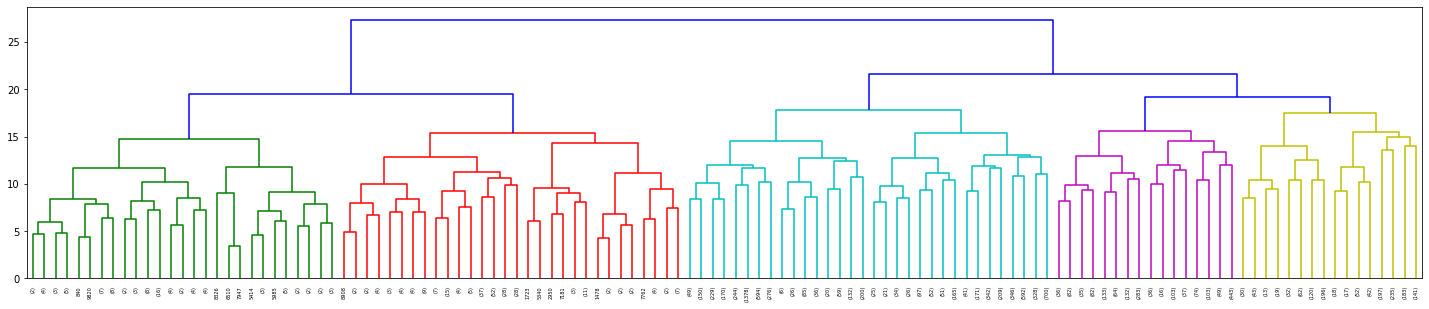

In [262]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=6,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

Now to find the optimal number of clusters we apply:
1. [fcluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) to form flat clusters from the hierarchical clustering defined by the linkage matrix ($Zd$).
1. [Silhouette scoring](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) to determine an appropriate number of clusters ($k$) or level in the dendogram. The Silhouette Coefficient ($S$) is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample where:
$$S = (b - a) / max(a, b)$$
 - ($S_1$) is computed using the "precomputed" Gower distances.
 - ($S_2$) is computed using predefined distance measures from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#) or [scipy](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html). BUT, this only works on our transformed and scaled features created earlier.
 

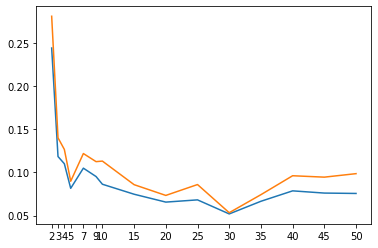

In [263]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))

for k in k_cand:
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score1 = silhouette_score(gd[:n,:n], cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy_scaled[:n], cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1,'s2':score2}
#     print(f'{k} : {score1} : {score2}')
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()])
plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()])
plt.xticks(k_cand);

In [291]:
tdf['k-medoids-7'] =results[7]['k']
tdf['k-medoids-40'] =results[40]['k']

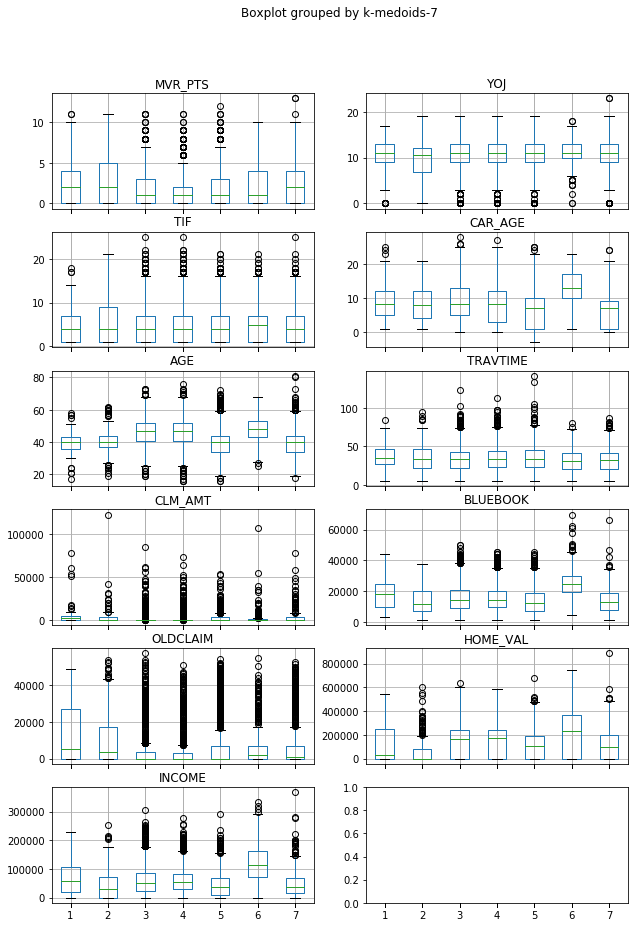

In [290]:
fig,axs = plt.subplots(6,2,figsize=(10,15),sharex=True)

for ax,feat in zip(axs.flatten(),num_features):
    pd.plotting.boxplot(tdf,column=[feat],by='k-medoids-7',ax=ax)
    ax.set_xlabel('')  
plt.tight_layout()

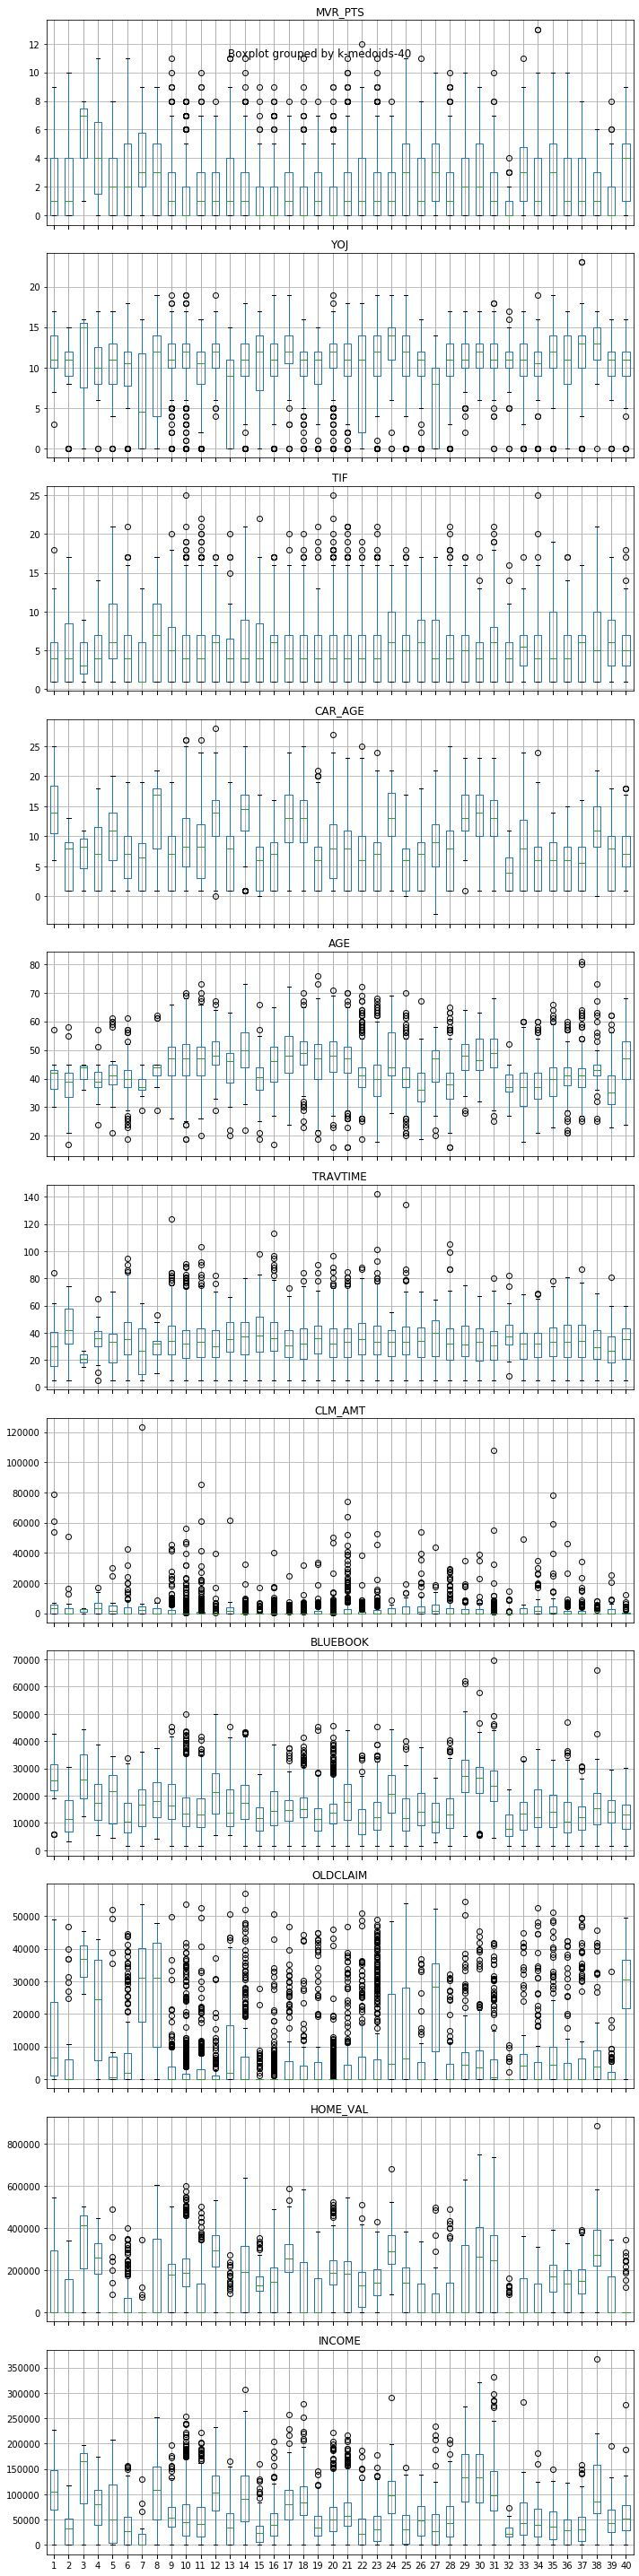

In [299]:
fig,axs = plt.subplots(11,1,figsize=(10,40),sharex=True)

for ax,feat in zip(axs.flatten(),num_features):
    pd.plotting.boxplot(tdf,column=[feat],by='k-medoids-40',ax=ax)
    ax.set_xlabel('')

plt.tight_layout()

# TO DO

- https://gist.github.com/AKST/d27b9006bb0f9670e370
- http://eric.univ-lyon2.fr/~ricco/cours/slides/en/classif_interpretation.pdf
- https://online.stat.psu.edu/stat414/node/116/


In [ ]:
# k-mediods python implmentation in scikit-learn-extra
# https://scikit-learn-extra.readthedocs.io/en/latest/install.html
# C++ build tools may be required on windows
# https://www.scivision.dev/python-windows-visual-c-14-required/

# or k-mediods in pyclustering
# https://pypi.org/project/pyclustering/

In [ ]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer,cluster_visualizer_multidim
from pyclustering.cluster.silhouette import silhouette

In [ ]:
# choose k clusters
results = dict()
for k in [7,10,20]:

    # initiate k random medoids
    # also sets k clusters
    initial_medoids = np.random.randint(0,1000,size=k)

    kmedoids_instance = kmedoids(gd,initial_medoids, data_type='distance_matrix')

    # run cluster analysis and obtain results
    %time kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    results[k] = clusters
    print(f'K={k} cluster sizes: {[len(i) for i in clusters]}')

***Silhouette scoring***
 - issue: clusters with n=1 cause fail

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# fimd k size and idx
# ar = list()
# for e,a in enumerate(results[30]):
#     g = [e]*len(a)
#     ar.extend(g)
#     if len(a) == 1:
#         print(e)

# list of scores
for k in results.keys():
    cluster_array = [e for e,k in enumerate(results[k]) for i in k]
    score1 = silhouette_score(gd, cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy, cluster_array,metric='correlation')
    print(f'{k} : {score1} : {score2}')

***Cluster using silhouette score to find $max(k)$***
- [visualizer seems to work with paierd list only](https://github.com/annoviko/pyclustering/issues/499)

In [ ]:
# search using silhouette score
# https://codedocs.xyz/annoviko/pyclustering/classpyclustering_1_1cluster_1_1silhouette_1_1silhouette__ksearch.html
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
import pickle

try:
    search_instance = pickle.load(os.path.join(DATA_PATH,'car-insurance-claim-data/kmode-search-6-8.pickle'), "rb" )
except:
    search_instance = silhouette_ksearch(sample, kmin=3, kmax=6, algorithm=silhouette_ksearch_type.KMEDOIDS).process()
    pickle.dump(search_instance, open(os.path.join(DATA_PATH,'car-insurance-claim-data/kmode-search-6-8.pickle'), "wb" ))

amount = search_instance.get_amount()
scores = search_instance.get_scores()
print("Scores: '%s'" % str(scores))

# Create instance of K-Medoids algorithm with optimal settings from search
initial_medoids = np.random.randint(0,n,size=amount)
kmedoids_instance = kmedoids(sample,initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

# capture results
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

In [ ]:
len(clusters), sample.shape

# Visualise

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy[:n])

In [ ]:
tsne_df = pd.DataFrame(tsne)

tsne_df['cluster'] = np.nan
for e,k in enumerate(clusters):
    print(e,len(k))
    tsne_df.iloc[k,-1] = e

In [ ]:
groups = tsne_df.groupby('cluster')

fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', label=name)
ax.legend()
plt.show()

# [CLARANS](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4)

In [ ]:
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
# from sklearn import datasets

# #import iris dataset from sklearn library
# iris =  datasets.load_iris();

# #get the iris data. It has 4 features, 3 classes and 150 data points.
# data = iris.data

# """!
# The pyclustering library clarans implementation requires
# list of lists as its input dataset.
# Thus we convert the data from numpy array to list.
# """
# data = data.tolist()

In [ ]:
data = Xy.to_numpy().tolist()

In [ ]:
#get a glimpse of dataset
print("A peek into the dataset : ",data[:4])


"""!
@brief Constructor of clustering algorithm CLARANS.
@details The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
@param[in] data: Input data that is presented as list of points (objects), each point should be represented by list or tuple.
@param[in] number_clusters: amount of clusters that should be allocated.
@param[in] numlocal: the number of local minima obtained (amount of iterations for solving the problem).
@param[in] maxneighbor: the maximum number of neighbors examined.        
"""
clarans_instance = clarans(data, 3, 4, 4);

#calls the clarans method 'process' to implement the algortihm
(ticks, result) = timedcall(clarans_instance.process);
print("Execution time : ", ticks, "\n");

#returns the clusters 
clusters = clarans_instance.get_clusters();

#returns the mediods 
medoids = clarans_instance.get_medoids();


print("Index of the points that are in a cluster : ",clusters)
print("The target class of each datapoint : ",iris.target)
print("The index of medoids that algorithm found to be best : ",medoids)

# *References*

- https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3
- https://medium.com/@rumman1988/clustering-categorical-and-numerical-datatype-using-gower-distance-ab89b3aa90d9
- https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://www.google.com/search?client=firefox-b-d&q=python+gower+distance
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
- https://discuss.analyticsvidhya.com/t/clustering-technique-for-mixed-numeric-and-categorical-variables/6753
- https://stackoverflow.com/questions/24196897/r-distance-matrix-and-clustering-for-mixed-and-large-dataset
- https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://rpubs.com/data_feelings/msda_data621_hw4
- https://pypi.org/project/gower/
- https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html
- https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05
- https://www.rdocumentation.org/packages/cluster/versions/2.1.0/topics/pam
- https://github.com/annoviko/pyclustering/issues/499
- https://stats.stackexchange.com/questions/2717/clustering-with-a-distance-matrix
- https://www.kaggle.com/fabiendaniel/customer-segmentation
- https://dkopczyk.quantee.co.uk/claim-prediction/ (http://web.archive.org/web/20190429040211/https://dkopczyk.quantee.co.uk/claim-prediction/)
- https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf
- https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4
- https://www.uio.no/studier/emner/matnat/math/nedlagte-emner/STK2510/v08/undervisningsmateriale/ch8b.pdf
- https://github.com/annoviko/pyclustering/issues/499
- https://stackoverflow.com/questions/3081066/what-techniques-exists-in-r-to-visualize-a-distance-matrix
- https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68
- https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data
- http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
- https://gist.github.com/AKST/d27b9006bb0f9670e370
